In [1]:
#!pip install textblob
import glob
import re
import pandas as pd
from textblob import TextBlob
import time
import dask

In [2]:
%%time
glob.glob("/CS5811/*.csv")

Wall time: 1 ms


['/CS5811\\recipes.csv',
 '/CS5811\\reviews.csv',
 '/CS5811\\review_classified.csv',
 '/CS5811\\review_classified_hpci.csv',
 '/CS5811\\Review_with_sentiment_class.csv']

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1, threads_per_worker=4, memory_limit = '2GB')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:60390 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


In [4]:
%%time
import dask.dataframe as dd
df = dd.read_csv("reviews.csv")

Wall time: 389 ms


In [5]:
df.partitions[0].compute()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z
...,...,...,...,...,...,...,...,...
185537,199024,26173,124295,Lisa in Cali,5,This is really delicious! I pounded flat and ...,2006-08-28T09:45:16Z,2006-08-28T09:45:16Z
185538,199025,116953,235751,MA in Florida,5,What a great idea and recipe! It would be a re...,2005-08-28T07:07:23Z,2005-08-28T07:07:23Z
185539,199026,78814,235751,MA in Florida,5,"Kittencal, this a a really great recipe. Even...",2005-08-28T07:23:56Z,2005-08-28T07:23:56Z
185540,199027,73488,235751,MA in Florida,5,Made these for our Easter family brunch and th...,2005-08-28T07:37:28Z,2005-08-28T07:37:28Z


In [6]:
df.shape

(Delayed('int-e870c257-ff58-44b9-8dc5-f8f4c03f0443'), 8)

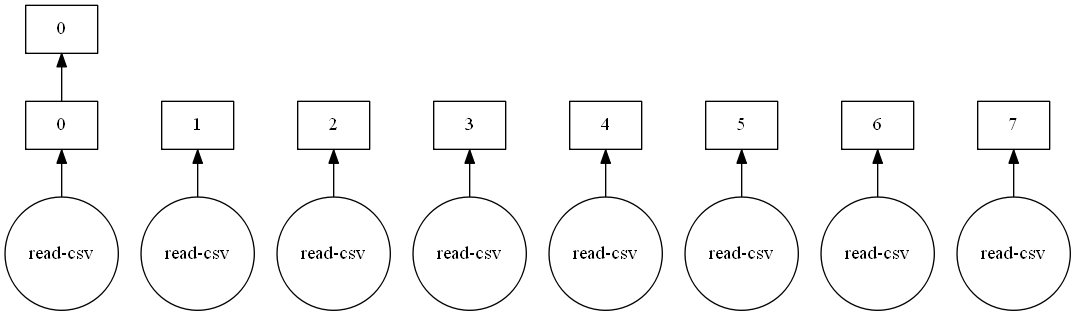

In [7]:
df.partitions[0].visualize()

In [8]:
def sentiment(x):
    text = str(x)
    polarity = TextBlob(text).sentiment.polarity*100
    sensitivity = TextBlob(text).sentiment.subjectivity*100
    
    if sensitivity > 50:
        if polarity>=0:
            if polarity >=40 and polarity <80:
                return "good"
            if polarity >=80 and polarity <=100:
                return "very good"
            if polarity <=39:
                return "average"

        if polarity<0:
            polarity = polarity * -1
            if polarity <=39:
                return "average"
            if polarity >=40 and polarity <80:
                return "poor"
            if polarity >=80 and polarity <=100:
                return "very poor"
    else:
        return "average"

In [9]:
%%time
df.Review = df.Review.map_partitions(sentiment)

Wall time: 57 ms


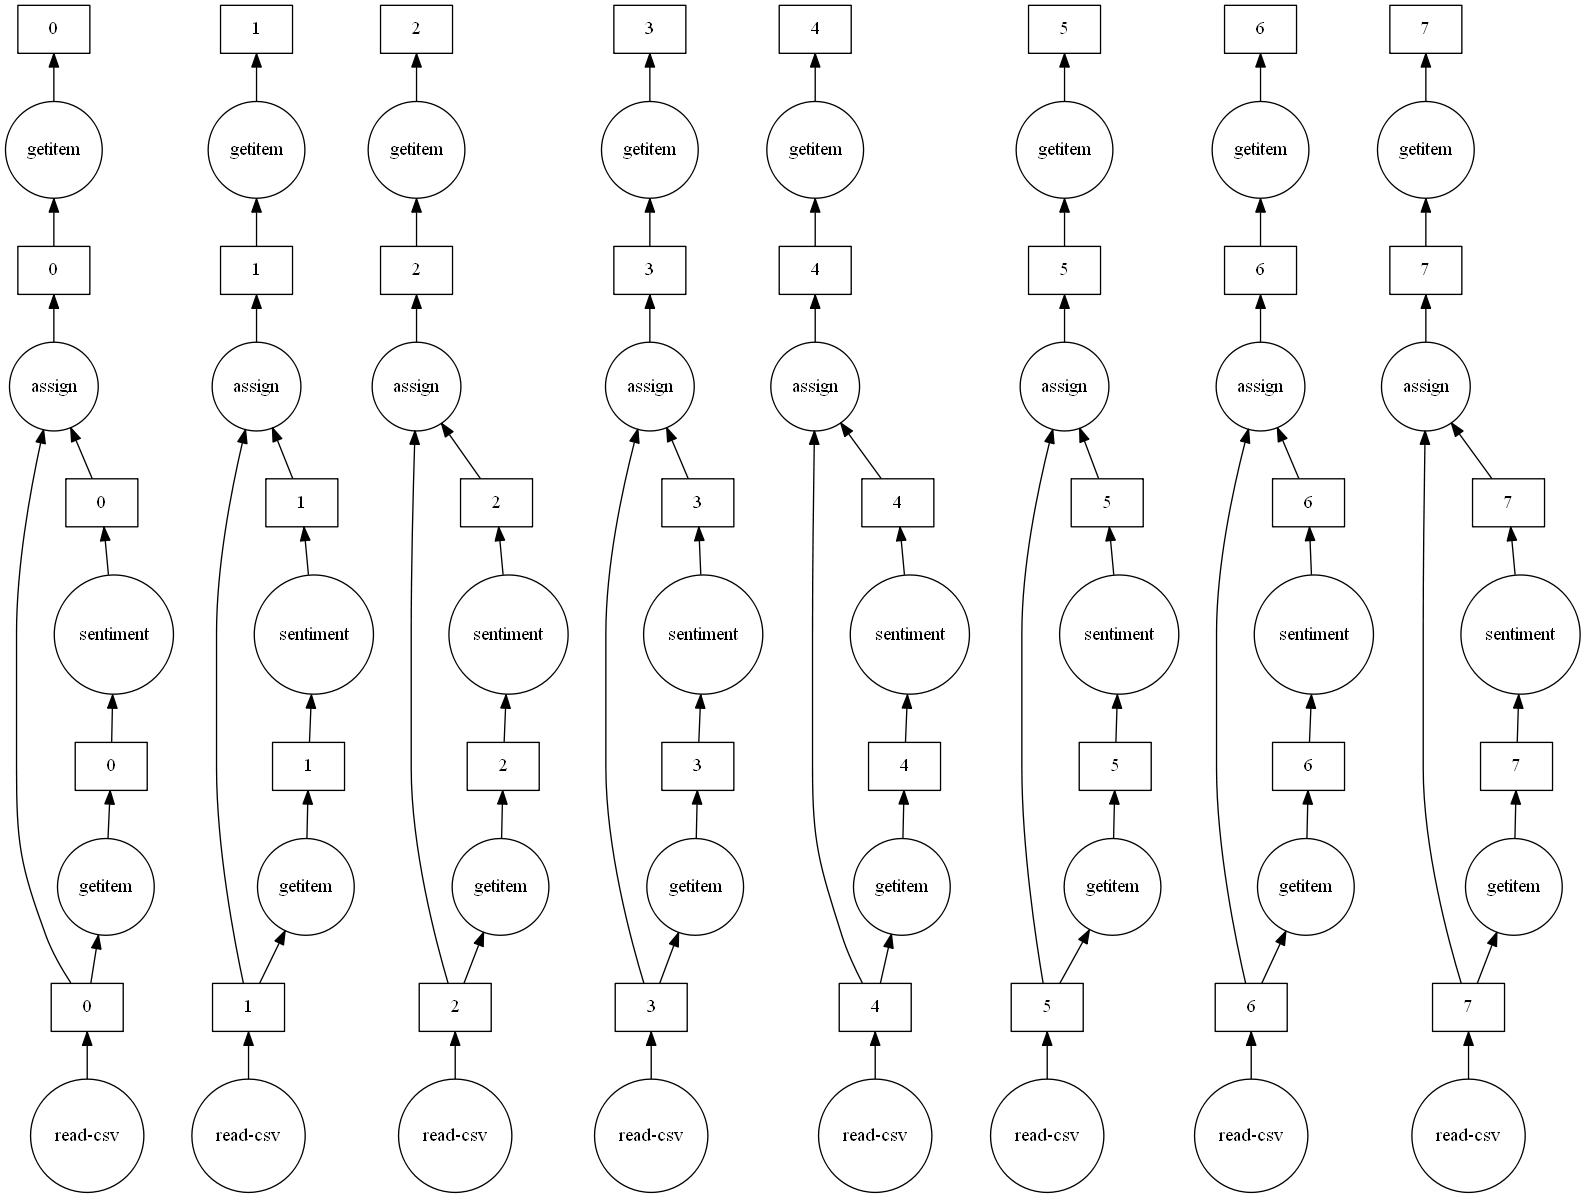

In [10]:
df.Review.visualize()

In [11]:
df.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,good,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,good,2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,good,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,good,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,good,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [12]:
df_x = df[['RecipeId', 'Review']]

In [13]:
df_y = df_x.dropna()

In [14]:
%%time
df_y.to_csv("review_classified_hpci.csv", single_file = True)

Wall time: 11.6 s


['E:/CS5811/review_classified_hpci.csv']